In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model
from sklearn.neural_network import MLPClassifier

In [3]:
from chiffresManuscrits_apprentissage import plot_confusion_matrix
from chiffresManuscrits_apprentissage import get_accuracy

# Utilisation d’un PMC pour la classification de Chiffres Manuscrits
# Notion d'optimisation d'une architecture

## Jeux d'apprentissage

### Choix de l'entrée du classifieur
Ici, on choisit le codage binaire (i.e. représenté par des -1 et des 1) que l'on va mettre en entrée du perceptron multicouches. Chaque représentation du chiffre manuscrit correspond à un vecteur.  
On peut utiliser le codage brut chiffre manuscrit avec son codage d'un 1 pour les pixels sur lesquels le stylo est passé et -1 là où il n'est pas passé. (L'imagette est mise sous forme de vecteur en mettant les lignes les unes à la suite des autres.)  

In [4]:
x = np.loadtxt("x.txt")

On peut aussi l'une des multiples variantes de codages associées à la représentation du nombre proposées.

In [5]:
hx = np.loadtxt("hx.txt")
hx_hy = np.loadtxt("hx_hy.txt")
pb_ph = np.loadtxt("pb_ph.txt")
pg_pd = np.loadtxt("pg_pd.txt")

On peut aussi choisir d'utiliser une combinaison.

In [6]:
hx_hy_pb_ph = np.loadtxt("hx_hy_pb_ph.txt")
hx_hy_pg_pd = np.loadtxt("hx_hy_pg_pd.txt")

Parmi, toutes ces possibilités, on en garde une comme entrée du réseau `X`.  
Pour la suite, on supprime les autres.

In [7]:
X = x.T
del x, hx, hx_hy, pb_ph, pg_pd, hx_hy_pb_ph, hx_hy_pg_pd

Pour ce qui est de la sortie, il s'agit d'un vecteur codant la classe  associée au chiffre manuscrit.  
La sortie désirée (`t` pour target) est, comme les entrées, un vecteur binaire (i.e. représenté par des -1 et des 1) de 10 colonnes (une pour chaque classe). Tous les éléments sont à -1 à l'exception de l'élément dont l'indice correspondant à la classe.   
Ainsi une représentation manuscrite des nombres 0, 3 et 9 auront tous leurs éléments à -1 à l'exception de leur, respectivement, premier, quatrième et dixième élément qui lui vaudra 1.  

In [8]:
t = np.loadtxt("t.txt").T
t_label_num = np.where(t==1)[1]
classes = np.unique(t_label_num)
class_label = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
t_label_str = [ class_label[i] for i in t_label_num]

**Pour la suite on à décider de remplacer les -1 par des 0.**  
Ainsi pour chaque chiffre on a neuf 0 et un 1. 
On a donc les probabilités d'appartenance aux classes de chiffres comme sorties désirées.  
La sortie fournit par le PMC correspondra ainsi à la probabilité estimée par le réseau.  
(Attention, un PMC n'a pas par défaut de contrainte pour respecter les axiomes des probabilités.  
Il pourra fournir des sorties inférieures à 0, supérieures à 1 ainsi qu'une somme des dix sorties elle aussi inférieure à 0 ou supérieure à 1.)

In [9]:
t[np.where(t==-1)] = 0

Il nous reste à réaliser nos ensembles d'apprentissage.  
On a $48 \times 10$ chiffres manuscrits qui correspondent à $48$ séries de $10$ chiffres ordonnés allant de $0$ à $9$.  
On va grossièrement prendre les premières séries pour l'apprentissage et les dernières pour le test.

### Réalisation des ensemble d'appre,tissage et de test
Pour l'apprentissage on ajoute un ensemble (`X_appVal`,`t_appVal`) contenant les données qui serviront pour constituer les ensembles d'apprentissage et de validation utilisées par le pmc pour apprendre.    
(Regarder pour avoir des valeurs de `n_train` et de  `validation_fraction` appropriées.)    
L'ensemble (`X_test`,`t_test`) correspondra à l'enseble de test. 

In [10]:
n_train = 28*10
# rescale the data, use the traditional train/test split
X_appVal, X_test = X[:n_train,:], X[n_train:,:]
t_appVal, t_test = t[:n_train,:], t[n_train:,:]
t_label_appVal, t_label_test = t_label_num[:n_train], t_label_num[n_train:]

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=4000,
                    alpha=1e-4,
                    validation_fraction=.7,
                    #solver='sgd', 
                    tol=1e-6, 
                    solver='lbfgs', learning_rate = 'adaptive',
                    random_state=1)
#mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
#                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
#                    learning_rate_init=.1)

mlp.fit(X_appVal, t_appVal)
print("Training set score: %f" % mlp.score(X_appVal, t_appVal))
print("Test set score: %f" % mlp.score(X_test, t_test))

Training set score: 1.000000
Test set score: 0.790000


## Apprentissage 

Dans cette partie, dans un cadre contraint, on va chercher à déterminer une architecture optimale.
Dans la suite, on s'intéressara à trois types d’architectures.
Pour cette architecture optimale, avec un jeu de poids associés, on calculera les performances en apprentissage validation et test.


### Optimisation de la première architecure 

Ici, on s'intéresse à un réseau linéaire entièrement connecté sans couche cachée.
On effectue donc une régression multilinéaire.    
[Ordinary least squares Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [12]:

ols = linear_model.LinearRegression()

#scaler = preprocessing.StandardScaler().fit(X_appVal)
#scaler = preprocessing.MinMaxScaler().fit(X_appVal)
#scaler = preprocessing.Normalizer().fit(X_appVal)
# X_scaled = scaler.transform(X_appVal)
ols.fit(X_appVal, t_appVal)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**On apprend des valeurs à 1 ou à 0 pour chacune des dix classes.**    
Ainsi, si les données sont bien apprises les valeurs estimées en sortie devraient être proches de 0 ou de 1.

In [13]:
t_appVal_prediction = ols.predict(X_appVal)
t_appVal_prediction

array([[ 1.00048828,  0.01611328,  0.00842285, ...,  0.01464844,
        -0.00830078, -0.00830078],
       [-0.01000977,  0.94189453,  0.09423828, ..., -0.03320312,
         0.04907227, -0.04589844],
       [ 0.01000977, -0.08203125,  1.00244141, ...,  0.03515625,
        -0.1105957 ,  0.01269531],
       ...,
       [ 0.01000977,  0.02832031, -0.00744629, ...,  0.74316406,
        -0.05395508,  0.14526367],
       [-0.01464844, -0.01904297, -0.03283691, ...,  0.01074219,
         0.99926758, -0.00170898],
       [-0.05932617,  0.04785156, -0.00195312, ...,  0.09570312,
        -0.01464844,  0.91357422]])

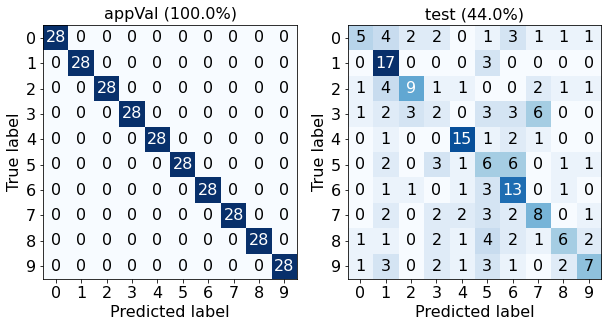

In [14]:
t_appVal_prediction = ols.predict(X_appVal)
t_label_appVal_prediction = np.argmax(t_appVal_prediction, axis=1)

t_test_prediction = ols.predict(X_test)
t_label_test_prediction = np.argmax(t_test_prediction, axis=1)
t_test_prediction.shape, t_label_test.shape, t_label_test_prediction.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

In [15]:
print('Mean squared error (appVal)           : %.2f'
      % mean_squared_error(t_label_appVal, t_label_appVal_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (appVal) : %.2f'
      % r2_score(t_label_appVal, t_label_appVal_prediction))
print()
print('Mean squared error (test)             : %.2f'
      % mean_squared_error(t_label_test, t_label_test_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (test)   : %.2f'
      % r2_score(t_label_test, t_label_test_prediction))


Mean squared error (appVal)           : 0.00
Coefficient of determination (appVal) : 1.00

Mean squared error (test)             : 8.29
Coefficient of determination (test)   : -0.00


### Optimisation de la seconde architecure 

Ici, on s'intéresse à un réseau Sigmoïdal entièrement connecté sans couche cachée.
On effectue donc une transformation non linéaire à la réponse fournie par une régression multilinéaire.    
[Logistic Regression (aka logit, MaxEnt) classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)    
(En regardant vous verrez que l'on peut peu-être faire mieux que ce qui est fait ici.)

In [16]:
X_appVal.shape, t_appVal.shape

((280, 256), (280, 10))

In [17]:
logitReg = linear_model.LogisticRegression(random_state=0,max_iter=1000)

#scaler = preprocessing.StandardScaler().fit(X_appVal)
#scaler = preprocessing.MinMaxScaler().fit(X_appVal)
#scaler = preprocessing.Normalizer().fit(X_appVal)
# X_scaled = scaler.transform(X_appVal)
logitReg.fit(X_appVal, t_label_appVal) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
t_label_appVal_prediction = logitReg.predict(X_appVal)
t_label_test_prediction = logitReg.predict(X_test)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

In [19]:
print('Mean squared error (appVal)           : %.2f'
      % mean_squared_error(t_label_appVal, t_label_appVal_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (appVal) : %.2f'
      % r2_score(t_label_appVal, t_label_appVal_prediction))
print()
print('Mean squared error (test)             : %.2f'
      % mean_squared_error(t_label_test, t_label_test_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (test)   : %.2f'
      % r2_score(t_label_test, t_label_test_prediction))


Mean squared error (appVal)           : 0.00
Coefficient of determination (appVal) : 1.00

Mean squared error (test)             : 1.87
Coefficient of determination (test)   : 0.77


### Optimisation de la troisième architecure 

Ici, le classifieur devient un réseau entièrement connecté à une couche caché.
Cela est éqiuvalent à utiliser une combinaison linéaires des réseaux sigmaodïdaux de la question précédente.    
[Multi-layer Perceptron classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)  
(En regardant vous verrez que l'on peut peu-être faire mieux que ce qui est fait ici.)

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=4000,
                    alpha=1e-4,
                    activation='tanh',
                    validation_fraction=.7,
                    #solver='sgd', 
                    tol=1e-6, 
                    solver='lbfgs', learning_rate = 'adaptive',
                    random_state=1)

mlp.fit(X_appVal, t_appVal)
print("Training set score: %f" % mlp.score(X_appVal, t_appVal))
print("Test set score: %f" % mlp.score(X_test, t_test))

Training set score: 1.000000
Test set score: 0.770000


In [21]:
t_appVal_prediction = mlp.predict(X_appVal)
t_appVal_prediction

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

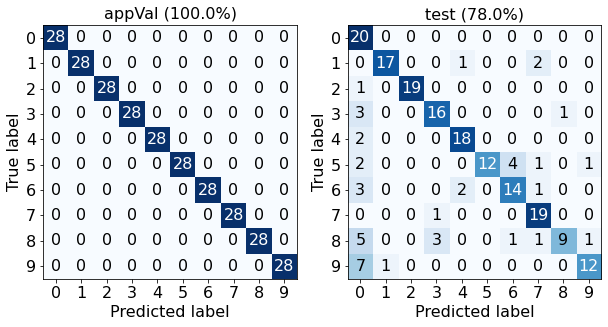

In [22]:
t_appVal_prediction = mlp.predict(X_appVal)
t_label_appVal_prediction = np.argmax(t_appVal_prediction, axis=1)

t_test_prediction = mlp.predict(X_test)
t_label_test_prediction = np.argmax(t_test_prediction, axis=1)
t_test_prediction.shape, t_label_test.shape, t_label_test_prediction.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)